In [1]:
import pandas as pd

In [2]:
from nsepy import get_history as gh
import datetime as dt

In [3]:

stk_data = pd.read_csv("Tatacoffee13_21.csv")
stk_data['Date'] = pd.to_datetime(stk_data['Date'])

# Filter data for the specified date range
start_date = dt.datetime(2021, 9, 1)
end_date = dt.datetime(2022, 2, 4)

date_range = stk_data[(stk_data['Date'] >= start_date) &(stk_data['Date'] <= end_date)]


In [4]:
date_range

,Date,Open,High,Low,Close
2144,2021-09-01,214.00,214.25,207.90,211.10
2145,2021-09-02,211.90,213.75,208.70,209.50
2146,2021-09-03,210.00,211.25,206.40,207.60
2147,2021-09-06,207.60,209.50,203.20,204.10
2148,2021-09-07,211.35,217.00,209.60,212.45
...,...,...,...,...,...
2220,2021-12-22,202.90,207.80,201.35,205.00
2221,2021-12-23,206.00,206.85,202.05,202.95
2222,2021-12-24,203.90,203.90,199.35,201.00
2223,2021-12-27,200.00,222.00,196.00,218.35


In [5]:
stk_data=stk_data[["Open","High","Low","Close"]]
stk_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2225 non-null   float64
 1   High    2225 non-null   float64
 2   Low     2225 non-null   float64
 3   Close   2225 non-null   float64
dtypes: float64(4)
memory usage: 69.7 KB


In [6]:
column="Close"

In [7]:
from sklearn.preprocessing import MinMaxScaler
Ms = MinMaxScaler()
data1= Ms.fit_transform(stk_data[[column]])
print("Len:",data1.shape)

Len: (2225, 1)


In [8]:
len(data1)

2225

In [9]:
training_size = round(len(data1 ) * 0.95)
print(training_size)
X_train=data1[:training_size]
X_test=data1[training_size:]
print("X_train length:",X_train.shape)
print("X_test length:",X_test.shape)
y_train=data1[:training_size]
y_test=data1[training_size:]
print("y_train length:",y_train.shape)
print("y_test length:",y_test.shape)

2114
X_train length: (2114, 1)
X_test length: (111, 1)
y_train length: (2114, 1)
y_test length: (111, 1)


In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np
orders=[(1,1,1),(1,1,2),(2,3,1),(2,2,2)]
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rmsemape(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mape

for i in orders:
    model = SARIMAX(data1, order=i, seasonal_order=(0, 0, 0, 12))
    model_fit = model.fit()
    y_pred = model_fit.predict(start=len(X_train), end=len(data1) - 1)

    # Calculate RMSE and MAPE
    mse, mape = rmsemape(y_test, y_pred)
    print("orders={} - RMSE: {:.2f}, MAPE: {:.2f}%".format(i, mse, mape))
    
    print("************")

orders=(1, 1, 1) - RMSE: 0.00, MAPE: 7.02%
************
orders=(1, 1, 2) - RMSE: 0.00, MAPE: 7.01%
************
orders=(2, 3, 1) - RMSE: 0.00, MAPE: 7.61%
************
orders=(2, 2, 2) - RMSE: 0.00, MAPE: 7.05%
************


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [12]:
len(y_pred)

111

In [13]:
from stockFunctions import graph
graph(y_test,y_pred,"Actual","Predicted","TataCoffee-Close-MA-Norm","Days","Prices")

<Figure size 1000x500 with 1 Axes>

In [14]:
len(data1)

2225

In [15]:
from stockFunctions import conversionSingle
aTestNormTable=conversionSingle(y_test,[column])
actual_stock_price_test_ori=Ms.inverse_transform(aTestNormTable)
actual_stock_price_test_oriA=conversionSingle(actual_stock_price_test_ori,[column])

In [16]:
from stockFunctions import conversionSingle
pTestNormTable=conversionSingle(y_pred,[column])
predicted_stock_price_test_ori=Ms.inverse_transform(pTestNormTable)
predicted_stock_price_test_oriP=conversionSingle(predicted_stock_price_test_ori,[column])

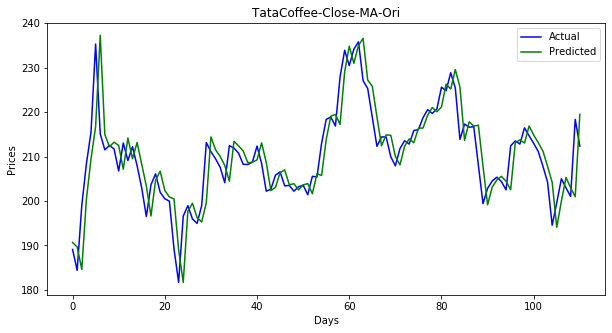

In [17]:
from stockFunctions import graph
graph(actual_stock_price_test_oriA,predicted_stock_price_test_oriP,"Actual","Predicted","TataCoffee-Close-MA-Ori","Days","Prices")

In [18]:
from stockFunctions import rmsemape
rmsemape(actual_stock_price_test_oriA,predicted_stock_price_test_oriP)

RMSE-Testset: 5.893255169566465
maPe-Testset: 0.020157027446301334


In [19]:
forecast=model_fit.predict(len(data1), len(data1))

In [20]:
forecast

array([0.10180459])

In [21]:
from stockFunctions import conversionSingle
fTestNormTable=conversionSingle(forecast,["Closefore"])
forecast_stock_price_test_ori=Ms.inverse_transform(fTestNormTable)
forecast_stock_price_test_oriF=conversionSingle(forecast_stock_price_test_ori,["Closefore"])

In [22]:
forecast_stock_price_test_oriF

,Closefore
0,212.165184


In [23]:
forecast_stock_price_test_oriF.to_csv("CloseSArima.csv",index=False)